In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.python.keras.models import Sequential


from tensorflow.keras.datasets import cifar10
import numpy as np

In [3]:
def create_denoising_autoencoder():
    input_img = Input(shape=(32, 32, 3))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder



In [4]:
# Cargar el dataset CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Normalizar los datos
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32')   / 255.

In [5]:

# Generar datos ruidosos
noise_factor = 0.10
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)

X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)



In [ ]:
autoencoder = create_denoising_autoencoder()


# Entrenar el autoencoder
autoencoder.fit(X_train_noisy, X_train, epochs=30, batch_size=256, shuffle=True, validation_data=(X_test_noisy, X_test))

In [ ]:
autoencoder.save('autoencoder.h5')

In [6]:
autoencoder_model = tf.keras.models.load_model('autoencoder.h5')


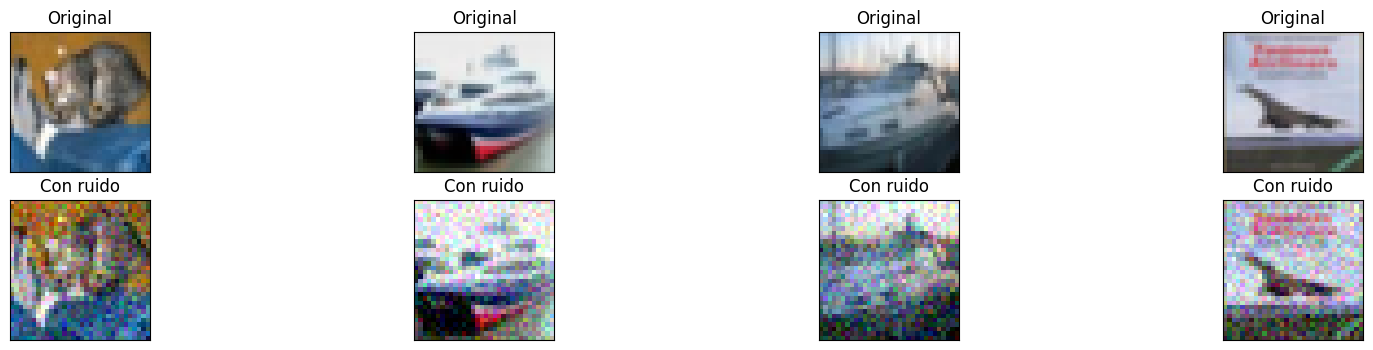

In [7]:
# Mostrar las imágenes originales y las imágenes con ruido
import matplotlib.pyplot as plt

n = 4
plt.figure(figsize=(20, 4))

for i in range(n):
    # Imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.title('Original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen con ruido
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_test_noisy[i])
    plt.title('Con ruido')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

1/1 [==============================] - 0s 17ms/step


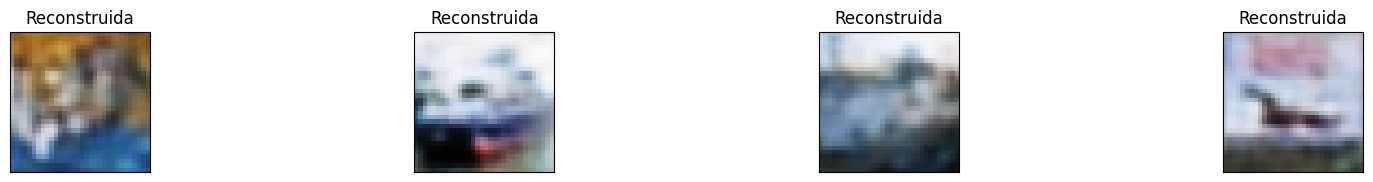

In [9]:
# Mostrar las imágenes reconstruidas
plt.figure(figsize=(20, 4))

for i in range(n):
    # Imagen reconstruida
    ax = plt.subplot(2, n, i + 1)
    reconstructed = autoencoder_model.predict(X_test_noisy[i].reshape(1, 32, 32, 3))
    plt.imshow(reconstructed.reshape(32, 32, 3))
    plt.title('Reconstruida')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [10]:
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input
from keras.applications.resnet_v2 import decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2
import os

In [11]:
modelo = ResNet50V2(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

In [12]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = modelo(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [14]:
img = image.image_utils.load_img(os.path.join('data','YellowLabradorLooking_new.jpg'), target_size=(224, 224))
img = image.image_utils.img_to_array(img)
resize = preprocess_input(np.expand_dims(img, axis=0))

image_probs = modelo.predict(resize)

1/1 [==============================] - 1s 655ms/step


In [15]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(208, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

In [16]:
resize_tensor = tf.convert_to_tensor(resize, dtype=tf.float32)

In [17]:
noise = create_adversarial_pattern(resize_tensor, label)

perturbated_img = resize + noise * 0.1
perturbated_img = tf.clip_by_value(perturbated_img, -1, 1)

prediction_noisy = modelo.predict(perturbated_img)


1/1 [==============================] - 0s 65ms/step


In [18]:
perturbated_img_resized = tf.image.resize(perturbated_img, [32, 32])
perturbated_img_resized = tf.reshape(perturbated_img_resized, [1, 32, 32, 3])

In [21]:
original_resized = tf.image.resize(resize, [32, 32])
original_resized = tf.reshape(original_resized, [1, 32, 32, 3])

prediction_original_resized = modelo.predict(original_resized)


1/1 [==============================] - 1s 633ms/step


In [22]:

reconstructed = autoencoder_model.predict(perturbated_img_resized)

reconstructed_resized = tf.image.resize(reconstructed, [224, 224]).numpy()  # Si 'reconstructed' proviene de un autoencoder
reconstructed_img = preprocess_input(reconstructed_resized[0:1])

# Predicción con la imagen reconstruida
prediction_reconstructed = modelo.predict(reconstructed_img)

print('Predicción normal:', decode_predictions(image_probs, top=3)[0])
print('Predicción normal redimensionada:', decode_predictions(prediction_original_resized, top=3)[0])
print('Predicción con ruido:', decode_predictions(prediction_noisy, top=3)[0])
print('Predicción reconstruida:', decode_predictions(prediction_reconstructed, top=3)[0])


1/1 [==============================] - 0s 77ms/step
Predicción normal: [('n02099712', 'Labrador_retriever', 0.97477674), ('n02099849', 'Chesapeake_Bay_retriever', 0.006618412), ('n02115641', 'dingo', 0.0039960826)]
Predicción normal redimensionada: [('n09421951', 'sandbar', 0.002494576), ('n09399592', 'promontory', 0.0023459666), ('n11879895', 'rapeseed', 0.0022592698)]
Predicción con ruido: [('n02113799', 'standard_poodle', 0.7690336), ('n02113712', 'miniature_poodle', 0.08373423), ('n02110806', 'basenji', 0.009640963)]
Predicción reconstruida: [('n06359193', 'web_site', 0.035990864), ('n03729826', 'matchstick', 0.034817252), ('n01930112', 'nematode', 0.026849873)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: cannot reshape array of size 3072 into shape (32,32)

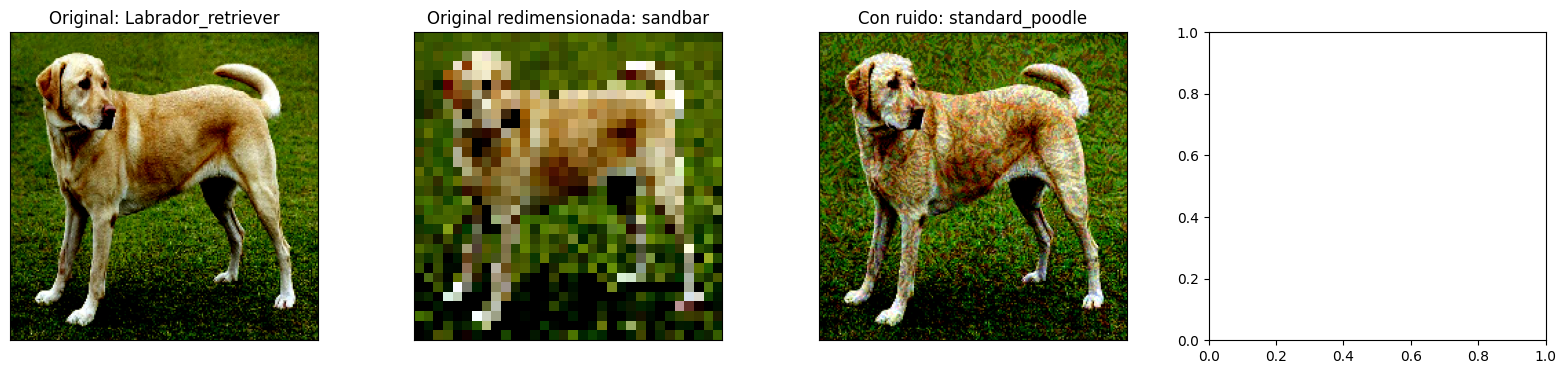

In [35]:
plt.figure(figsize=(20, 4))

# Imagen original
ax = plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title('Original: ' + decode_predictions(image_probs, top=3)[0][0][1])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Imagen original redimensionada
ax = plt.subplot(1, 4, 2)
plt.imshow(original_resized[0])
plt.title('Original redimensionada: ' + decode_predictions(prediction_original_resized, top=3)[0][0][1])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Imagen con ruido
ax = plt.subplot(1, 4, 3)
plt.imshow(perturbated_img[0])
plt.title('Con ruido: ' + decode_predictions(prediction_noisy, top=3)[0][0][1])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Imagen reconstruida
ax = plt.subplot(1, 4, 4)
plt.imshow(reconstructed.reshape(32, 32, 3))
plt.title('Reconstruida: ' + decode_predictions(prediction_reconstructed, top=3)[0][0][1])
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)